# Four Coloring Problem

## Graph Construction

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

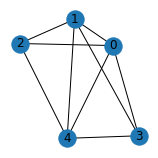

In [99]:
# bigger graph
graph_edges = [(0, 1), (0,2), (1,2), (1,3), (3,4), (0, 4), (1, 4), (0, 3), (2, 4)]
N = 5
G = nx.Graph()
G.add_edges_from(graph_edges)
plt.figure(figsize=(2,2))
nx.draw(G, labels={node: node for node in G.nodes()})
plt.show()

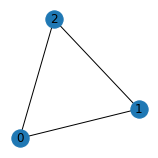

In [104]:
graph_edges = [(0, 1), (0,2), (1,2)]
N = 3
G = nx.Graph()
G.add_edges_from(graph_edges)
plt.figure(figsize=(2,2))
nx.draw(G, labels={node: node for node in G.nodes()})
plt.show()

## Cost Hamiltonian

In [25]:
from typing import List, Tuple, Any, Dict
from pytket.utils import QubitPauliOperator
from pytket.pauli import QubitPauliString, Pauli
from pytket import Qubit

In [98]:
def qaoa_graph_to_cost_hamiltonian(edges, cost_angle: float) -> QubitPauliOperator:
    qpo_dict = defaultdict(lambda:0)
    for (i, j) in edges:
        qpo_dict[QubitPauliString()]+=3/4
        qpo_dict[QubitPauliString([Qubit(i), Qubit(j)], [Pauli.Z]*2)]-=1/4
        qpo_dict[QubitPauliString([Qubit(N+i), Qubit(N+j)], [Pauli.Z]*2)]-=1/4
        qpo_dict[QubitPauliString([Qubit(i), Qubit(j), Qubit(N+i), Qubit(N+j)], [Pauli.Z]*4)]-=1/4
    for key in qpo_dict.keys():
        qpo_dict[key]*=cost_angle
    return QubitPauliOperator(qpo_dict)

cost_angle = 1.0
cost_ham_qpo = qaoa_graph_to_cost_hamiltonian(graph_edges, cost_angle)
print(cost_ham_qpo)

{(): 2.25000000000000, (Zq[0], Zq[1]): -0.250000000000000, (Zq[3], Zq[4]): -0.250000000000000, (Zq[0], Zq[1], Zq[3], Zq[4]): -0.250000000000000, (Zq[0], Zq[2]): -0.250000000000000, (Zq[3], Zq[5]): -0.250000000000000, (Zq[0], Zq[2], Zq[3], Zq[5]): -0.250000000000000, (Zq[1], Zq[2]): -0.250000000000000, (Zq[4], Zq[5]): -0.250000000000000, (Zq[1], Zq[2], Zq[4], Zq[5]): -0.250000000000000}


In [84]:
from pytket import Circuit

circ = Circuit(10)
# circ.X(0)
# circ.X(N+1)
# circ.X(N+4)
# circ.X(4)
# circ.X(7)
vec = circ.get_statevector()

In [85]:
cost_ham_qpo.state_expectation(vec)

0j

## Cost Hamiltonian Circuit

In [86]:
from pytket.utils import gen_term_sequence_circuit
from pytket import Circuit
from pytket.circuit import display

cost_ham_circuit = gen_term_sequence_circuit(cost_ham_qpo, Circuit(N*2))
display.render_circuit_jupyter(cost_ham_circuit)

In [37]:
from pytket.transform import Transform

Transform.DecomposeBoxes().apply(cost_ham_circuit)
display.render_circuit_jupyter(cost_ham_circuit)

## Mixer Hamiltonian

In [39]:
mixer_angle = 0.8
mixer_ham_qpo =  QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer_angle for i in range(N*2)})
mixer_ham_circuit = gen_term_sequence_circuit(mixer_ham_qpo, Circuit(N*2))
Transform.DecomposeBoxes().apply(mixer_ham_circuit)
display.render_circuit_jupyter(mixer_ham_circuit)

## Initial Circuit

In [40]:
def qaoa_initial_circuit(n_qubits: int) -> Circuit:
    c = Circuit(n_qubits)
    for i in range(n_qubits):
        c.H(i)
    return c

superposition_circuit = qaoa_initial_circuit(N)

display.render_circuit_jupyter(superposition_circuit)

## Putting it all together

In [49]:
def qaoa_circuit(edges,
                         n_nodes: int,
                         mixer_angles: List[float],
                         cost_angles: List[float]) -> Circuit:
    
    assert len(mixer_angles) == len(cost_angles)
    
    # initial state
    qaoa_circuit = qaoa_initial_circuit(n_nodes*2)
    
    # add cost and mixer terms to state
    for cost, mixer in zip(cost_angles, mixer_angles):
        cost_ham = qaoa_graph_to_cost_hamiltonian(edges, cost)
        mixer_ham = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer for i in range(n_nodes*2)})
        qaoa_circuit.append(gen_term_sequence_circuit(cost_ham, Circuit(n_nodes*2)))
        qaoa_circuit.append(gen_term_sequence_circuit(mixer_ham, Circuit(n_nodes*2)))
        
    Transform.DecomposeBoxes().apply(qaoa_circuit)
    return qaoa_circuit

In [89]:
from typing import List, Tuple
from pytket.backends.backendresult import BackendResult

def edges_fail(edges, meas):
    num = 0
    for (i, j) in edges:
        num+=(meas[i] == meas[j] and meas[N+i] == meas[N+j])
    return num

def get_energy(edges, results: BackendResult) -> float:
    dist = results.get_distribution()
    energy = 0
    for meas, prob in dist.items():
        energy += (len(edges) - edges_fail(edges, meas))*prob

    return energy

In [105]:
from pytket.backends.backend import Backend
from typing import Callable
import numpy as np

def qaoa_instance(
    backend: Backend,
    compiler_pass: Callable[[Circuit], bool],
    guess_mixer_angles: np.array,
    guess_cost_angles: np.array,
    seed: int,
    shots: int = 5000,
) -> float:
    # step 1: get state guess
    my_prep_circuit = qaoa_circuit(
        graph_edges, N, guess_mixer_angles, guess_cost_angles
    )
    measured_circ = my_prep_circuit.copy().measure_all()
    compiler_pass(measured_circ)
    res = backend.run_circuit(measured_circ, shots, seed=seed)

    return get_energy(graph_edges, res)

In [110]:
np.random.normal([0.5, 0.6], [1, 1])

array([ 0.68100884, -1.30967135])

In [112]:
def qaoa_optimise_energy(compiler_pass: Callable[[Circuit], bool],
                         backend: Backend,
                         iterations: int = 100,
                         n: int = 3,
                         shots: int = 5000,
                         seed: int= 12345):
    
    highest_energy = -1000   
    best_guess_mixer_angles = [0 for i in range(n)]    
    best_guess_cost_angles = [0 for i in range(n)]
    rng = np.random.default_rng(seed)
    # guess some angles (iterations)-times and try if they are better than the best angles found before
    
    for i in range(iterations):
        
        guess_mixer_angles = np.clip(np.random.normal(best_guess_mixer_angles, [1]*n), 0, 1)
        guess_cost_angles = np.clip(np.random.normal(best_guess_cost_angles, [1]*n), 0, 1)
        
        qaoa_energy = qaoa_instance(backend,
                                    compiler_pass,
                                    guess_mixer_angles,
                                    guess_cost_angles,
                                    seed=seed,
                                    shots=shots)
        
        if(qaoa_energy > highest_energy):
            
            print("new highest energy found: ", qaoa_energy)
            
            best_guess_mixer_angles = np.round(guess_mixer_angles, 3)
            best_guess_cost_angles = np.round(guess_cost_angles, 3)
            highest_energy = qaoa_energy
            
    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    return best_guess_mixer_angles, best_guess_cost_angles

In [113]:
def qaoa_calculate(backend: Backend,
                   compiler_pass: Callable[[Circuit], bool],
                   shots: int = 5000,
                   iterations: int = 100,
                   seed: int = 12345,
                  ) -> BackendResult:
    
    # find the parameters for the highest energy
    best_mixer, best_cost = qaoa_optimise_energy(compiler_pass,
                                                 backend,
                                                 iterations,
                                                 10,
                                                 shots=shots,
                                                 seed=seed)
    
    # get the circuit with the final parameters of the optimisation:
    my_qaoa_circuit = qaoa_circuit(graph_edges, N,
                                           best_mixer,
                                           best_cost)

    my_qaoa_circuit.measure_all()

    compiler_pass(my_qaoa_circuit)
    handle = backend.process_circuit(my_qaoa_circuit, shots, seed=seed)

    result = backend.get_result(handle)    
    
    return result

In [114]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
comp = backend.get_compiled_circuit

In [115]:
%%time
res = qaoa_calculate(backend, backend.default_compilation_pass(2).apply, shots = 100, iterations = 100, seed=43278)

new highest energy found:  1.760000000000001
new highest energy found:  2.5500000000000007
new highest energy found:  2.630000000000001
new highest energy found:  2.71
new highest energy found:  2.7200000000000006
highest energy:  2.7200000000000006
best guess mixer angles:  [1.   1.   0.   0.   1.   0.   0.   0.   0.12 1.  ]
best guess cost angles:  [1.    0.206 0.99  0.    0.524 0.    0.    0.912 1.    0.   ]
CPU times: user 3min 4s, sys: 87.3 ms, total: 3min 4s
Wall time: 3min 4s


In [70]:
def prob_each_node(dist):
    p = [0]*N*2
    for meas, prob in dist.items():
        for ind, val in enumerate(meas):
            if (val == 1): 
                p[ind] +=prob
    return p

In [109]:
res.get_distribution()

{(0, 0, 0, 0, 0, 0): 0.01,
 (0, 0, 0, 1, 1, 1): 0.01,
 (0, 0, 1, 0, 1, 0): 0.05,
 (0, 0, 1, 0, 1, 1): 0.03,
 (0, 0, 1, 1, 0, 0): 0.03,
 (0, 0, 1, 1, 0, 1): 0.04,
 (0, 0, 1, 1, 1, 0): 0.01,
 (0, 1, 0, 0, 0, 1): 0.04,
 (0, 1, 0, 0, 1, 1): 0.04,
 (0, 1, 0, 1, 0, 0): 0.07,
 (0, 1, 0, 1, 1, 0): 0.02,
 (0, 1, 1, 0, 0, 1): 0.06,
 (0, 1, 1, 0, 1, 0): 0.05,
 (0, 1, 1, 1, 0, 0): 0.01,
 (0, 1, 1, 1, 0, 1): 0.03,
 (0, 1, 1, 1, 1, 0): 0.05,
 (1, 0, 0, 0, 0, 1): 0.01,
 (1, 0, 0, 0, 1, 0): 0.05,
 (1, 0, 0, 0, 1, 1): 0.02,
 (1, 0, 0, 1, 0, 1): 0.05,
 (1, 0, 0, 1, 1, 0): 0.03,
 (1, 0, 1, 0, 0, 1): 0.04,
 (1, 0, 1, 0, 1, 0): 0.01,
 (1, 0, 1, 0, 1, 1): 0.05,
 (1, 0, 1, 1, 0, 0): 0.02,
 (1, 0, 1, 1, 1, 0): 0.03,
 (1, 1, 0, 0, 1, 0): 0.02,
 (1, 1, 0, 0, 1, 1): 0.03,
 (1, 1, 0, 1, 0, 0): 0.05,
 (1, 1, 0, 1, 0, 1): 0.04}

In [71]:
prob_each_node(res.get_distribution())

[0.4200000000000002,
 0.5700000000000003,
 0.4300000000000002,
 0.47000000000000025,
 0.5400000000000003,
 0.5000000000000002,
 0.5700000000000003,
 0.48000000000000026,
 0.4800000000000003,
 0.49000000000000027]

In [151]:
get_energy(adj, res)

-0.32600000000000007